In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [4]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [5]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [6]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-01-26 14:47:37--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.007s  

2021-01-26 14:47:38 (8.79 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



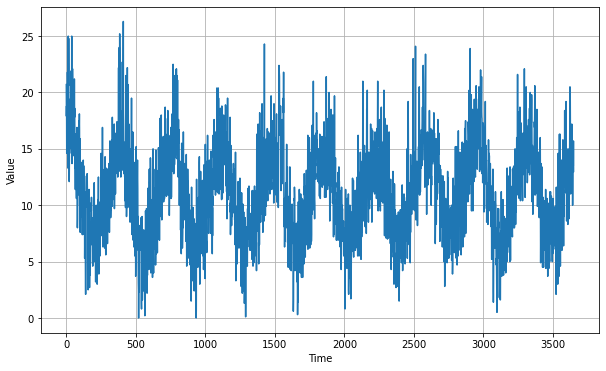

In [58]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for num, row in enumerate(reader):
    time_step.append(num)
    temps.append(float(row[1]))
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [59]:
series[:10], time[:10]

(array([20.7, 17.9, 18.8, 14.6, 15.8, 15.8, 15.8, 17.4, 21.8, 20. ]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [60]:
split_time = 2500
time_train = time[:split_time]# YOUR CODE HERE
x_train = series[:split_time]# YOUR CODE HERE
time_valid = time[split_time:]# YOUR CODE HERE
x_valid = series[split_time:]# YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [61]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(dataset)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda w: (w[:-1], w[1:])) # To use LSTM y labels
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [95]:
def model_forecast(model, series, window_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(window_size))
  dataset = dataset.batch(32).prefetch(1)

  pred = model.predict(dataset)
  return pred

In [73]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [87]:
model = tf.keras.models.Sequential([tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=[None, window_size, 1])),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                                    tf.keras.layers.Conv1D(32, kernel_size=5, strides=1, padding='causal', activation='relu'),
                                    tf.keras.layers.Dense(256, activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(32, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x* 400)
])

In [88]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 6s 39ms/step - loss: 40.2671 - mae: 40.7651
Epoch 2/100
10/10 [==============================] - 0s 32ms/step - loss: 39.3323 - mae: 39.8302
Epoch 3/100
10/10 [==============================] - 0s 32ms/step - loss: 37.6244 - mae: 38.1220
Epoch 4/100
10/10 [==============================] - 0s 30ms/step - loss: 35.5548 - mae: 36.0523
Epoch 5/100
10/10 [==============================] - 0s 32ms/step - loss: 33.7004 - mae: 34.1977
Epoch 6/100
10/10 [==============================] - 0s 30ms/step - loss: 31.5984 - mae: 32.0953
Epoch 7/100
10/10 [==============================] - 0s 32ms/step - loss: 29.6420 - mae: 30.1386
Epoch 8/100
10/10 [==============================] - 0s 33ms/step - loss: 27.8274 - mae: 28.3236
Epoch 9/100
10/10 [==============================] - 0s 32ms/step - loss: 26.2983 - mae: 26.7943
Epoch 10/100
10/10 [==============================] - 0s 32ms/step - loss: 24.8928 - mae: 25.3885
Epoch 11/100
10/10 [=========

(1e-08, 0.0001, 0.0, 60.0)

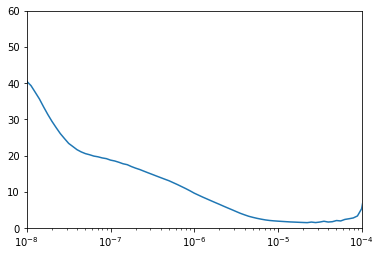

In [89]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [105]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=[None, window_size, 1])),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
                                    tf.keras.layers.Conv1D(64, kernel_size=5, strides=1, padding='causal', activation='relu'),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(32, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x* 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 6s 21ms/step - loss: 29.8788 - mae: 30.3748
Epoch 2/150
25/25 [==============================] - 1s 18ms/step - loss: 4.5947 - mae: 5.0772
Epoch 3/150
25/25 [==============================] - 1s 20ms/step - loss: 2.1376 - mae: 2.5962
Epoch 4/150
25/25 [==============================] - 1s 22ms/step - loss: 1.5706 - mae: 2.0164
Epoch 5/150
25/25 [==============================] - 1s 20ms/step - loss: 1.4398 - mae: 1.8824
Epoch 6/150
25/25 [==============================] - 1s 21ms/step - loss: 1.3524 - mae: 1.7916
Epoch 7/150
25/25 [==============================] - 1s 22ms/step - loss: 1.3001 - mae: 1.7387
Epoch 8/150
25/25 [==============================] - 1s 21ms/step - loss: 1.2798 - mae: 1.7173
Epoch 9/150
25/25 [==============================] - 1s 20ms/step - loss: 1.2279 - mae: 1.6628
Epoch 10/150
25/25 [==============================] - 1s 19ms/step - loss: 1.2043 - mae: 1.6379
Epoch 11/150
25/25 [===========================

In [106]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

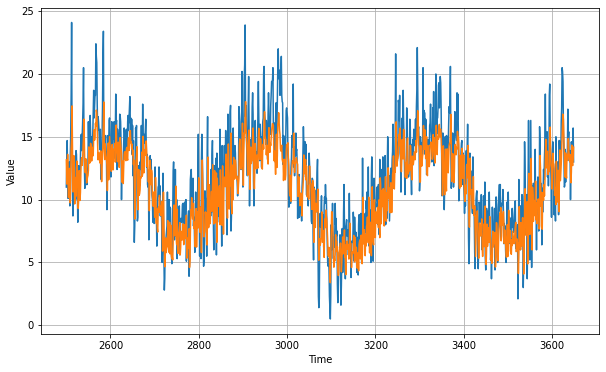

In [107]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [108]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

2.0256357

In [109]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[13.159216 11.237817 11.536324 ... 12.709984 13.141463 14.174596]
